In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [57]:
import numpy as np
import pandas as pd

from src.Evaluation.dcdistances.dctree import DCTree
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score as ARI
from src.utils.metrics import SELECTED_METRICS

from src.utils.metrics import create_and_rescale_df
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets

CACHE_PATH = "/export/share/pascalw777dm/DISCO/.cache/"


def get_kcenter_and_dbscan_clusterings(X, ks):
    dctree = DCTree(X, min_points=5, min_points_mr=2)
    eps_list = [dctree.get_eps_for_k(k) for k in ks]
    kcenter_labels = [dctree.get_k_center(k) for k in ks]
    dbscan_labels = [DBSCAN(eps).fit(X).labels_ for eps in eps_list]
    return eps_list, kcenter_labels, dbscan_labels

def create_df_ari(ari_values, ks):
    df_ari = pd.DataFrame(ari_values, columns=["ARI"])
    df_ari["k"] = ks
    df_ari["measure"] = "ARI"
    return df_ari


def get_peak_positions(df, ks):
    cvi_scores = df.to_numpy()
    peak_positions = []
    all_values = []
    for metric in SELECTED_METRICS:
        values = cvi_scores[cvi_scores[:, 1] == metric][:, 3]
        all_values.append(values)
        # print(metric, values)
        max_idx = np.argmax(values)
        peak_positions.append([ks[max_idx], values[max_idx], max_idx])
    peak_positions = np.array(peak_positions)
    return peak_positions

def calc_ari_values(ground_truth_labels, labels_list, ks):
    return [(ARI(ground_truth_labels, labels_list[i])) for i, _ in enumerate(ks)]
    return [(ARI(ground_truth_labels[labels_list[i] != -1], labels_list[i][labels_list[i] != -1])) for i, _ in enumerate(ks)]


def calculate_data(dataset, cached_name, ks=range(2, 20)):
    X, l = dataset.data_cached

    eps_list, kcenter_labels, dbscan_labels = get_kcenter_and_dbscan_clusterings(X, ks)
    kcenter_datasets = [[(X, kcenter_labels[i])] for i, k in enumerate(ks)]
    dbscan_datasets = [[(X, dbscan_labels[i])] for i, k in enumerate(ks)]

    if not os.path.exists(f"{CACHE_PATH}find_dbscan_eps##ARIs##{cached_name}.pkl"):
        print(f"Cached version '{CACHE_PATH}find_dbscan_eps##ARIs##{cached_name}.pkl' not found.")
    ari_values = cache(f"find_dbscan_eps##ARIs##{cached_name}", calc_ari_values, [l, dbscan_labels, ks], recalc=True)
    df_ari = create_df_ari(ari_values, ks)

    if not os.path.exists(f"{CACHE_PATH}find_dbscan_eps##CVIs##{cached_name}.pkl"):
        print(f"Cached version '{CACHE_PATH}find_dbscan_eps##CVIs##{cached_name}.pkl' not found.")
    eval_results = cache(
        f"find_dbscan_eps##CVIs##{cached_name}",
        calc_eval_measures_for_multiple_datasets,
        [dbscan_datasets, ks],
        {"n_jobs": 50},
    )

    df = create_and_rescale_df(eval_results)
    peak_positions = get_peak_positions(df, ks)

    return df_ari, df, ks, eps_list, peak_positions, ari_values, l, dbscan_labels

In [73]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot
import seaborn as sns


def plot_func(df_ari, df, ks, eps_list, peak_positions, ari_values, l, dbscan_labels, title=None, save_name=None):
    eps = 0.2
    x_range = ks[0] - eps, ks[-1] + eps

    palette = ["black"] + sns.color_palette("bright")[0:3] + ["darkgreen"] + sns.color_palette("bright")[4:-1]
    np.array(list(palette), dtype=object)
    palette = palette[: len(peak_positions)]

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [3, 1]})

    # CVIs
    plot_lineplot(
        df,
        "dataset",
        "value",
        "measure",
        order=SELECTED_METRICS,
        x_label="$\\epsilon$",
        y_label="CVI",
        x_range=x_range,
        y_range=(None, None),
        figsize=(10, 5.5),
        # figsize=(10, 7.5),
        sizes=[3] + [1] * 10,
        markersize=9,
        palette=palette,
        fig=fig,
        ax=axes[0],
    )
    ax1 = axes[0]
    ax2 = ax1.twiny()
    ax2.set_xlabel("$k$", labelpad=10)
    n_l = [len(set(l[l != -1])) for l in dbscan_labels]
    ax2.set_xticks(ks, n_l)
    ax2.set_xlim(*x_range)
    # ax2.tick_params(axis="x", which="major", pad=15)

    ax1.set_ylim((-0.1, None))


    ax1.set_facecolor("none")
    ax1.set_axisbelow(True)
    ax1.spines["right"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax2.grid(color="lightgray")  # , linestyle="dashed")#
    ax2.set_zorder(-1)

    # ax1.set_xlabel("$\\epsilon$", labelpad=5)
    # ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)
    ax1.set_xlabel("")
    ax1.set_xticks([])
    # ax1.axvspan(len(set(l[l != -1])) - 0.2, len(set(l[l != -1])) + 0.2, alpha=0.3, color="red")
    x_peak, y_peak = np.argmax(ari_values) + ks[0], max(ari_values)
    ax1.axvspan(x_peak - 0.2, x_peak + 0.2, alpha=0.3, color="red")
    ax1.get_legend().set_bbox_to_anchor((0.5, 1.18))

    markers = ["o"] + ["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"]
    markers = np.array(markers)[: len(peak_positions)]

    for i in range(len(peak_positions)-1, -1, -1):
        ax1.scatter(peak_positions[i, 0], peak_positions[i, 1], s=180, marker="o", color=palette[i], zorder=3)

    # ARIs
    eps = 0.2
    x_range = ks[0] - eps, ks[-1] + eps

    ax = sns.lineplot(
        data=df_ari,
        x="k",
        y="ARI",
        size="measure",
        sizes=[2],
        legend=False,
        color="red",
        ax=axes[1],
        marker="o",
        markersize=8,
    )

    ax.set_xlim(*x_range)

    ### Coloring of the plot
    ax.set_facecolor("white")
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["right"].set_color("white")
    ax.spines["top"].set_color("white")
    ax.grid(color="lightgray")

    ax1 = axes[1]
    ax2 = ax1.twiny()
    # ax2.set_xlabel("$k$", labelpad=10)
    # ax2.set_xticks(ks)
    # ax2.set_xlim(*x_range)
    ax2.set_xticks([])
    # ax2.tick_params(axis="x", which="major", pad=15)

    ax1.set_xlabel("$\\epsilon$", labelpad=5)
    ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)

    x_peak, y_peak = np.argmax(ari_values) + ks[0], max(ari_values)
    ax1.axvspan(x_peak - 0.2, x_peak + 0.2, alpha=0.3, color="red")
    ax1.scatter(x_peak, y_peak, s=150, marker="o", color="red", zorder=3)

    ax1.set_yticks([0,0.5, 1]) #, ["0.00", "0.50", "1.00"])
    ax1.set_ylim((-0.1, 1.1))
    # ax1.set_ylim((0.35, 0.7))

    if title:
        plt.title(title)

    plt.tight_layout()

    plt.subplots_adjust(wspace=0.0, hspace=0.075)  # CHANGE SPACING HERE BETWEEN THE CLUSTER PLOTS
    if save_name:
        plt.savefig(f"imgs/find_eps_dbscan_ari/{save_name}.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

In [54]:
from datasets.density_datasets import Datasets as DensityDatasets
from datasets.real_world_datasets import Datasets as RealWorldDatasets

ks = range(15,45)
df_ari, df, ks, eps_list, peak_positions, ari_values, l, dbscan_labels = calculate_data(
    RealWorldDatasets.COIL20, "COIL20_15_45", ks
)

In [55]:
ks = range(15, 35)

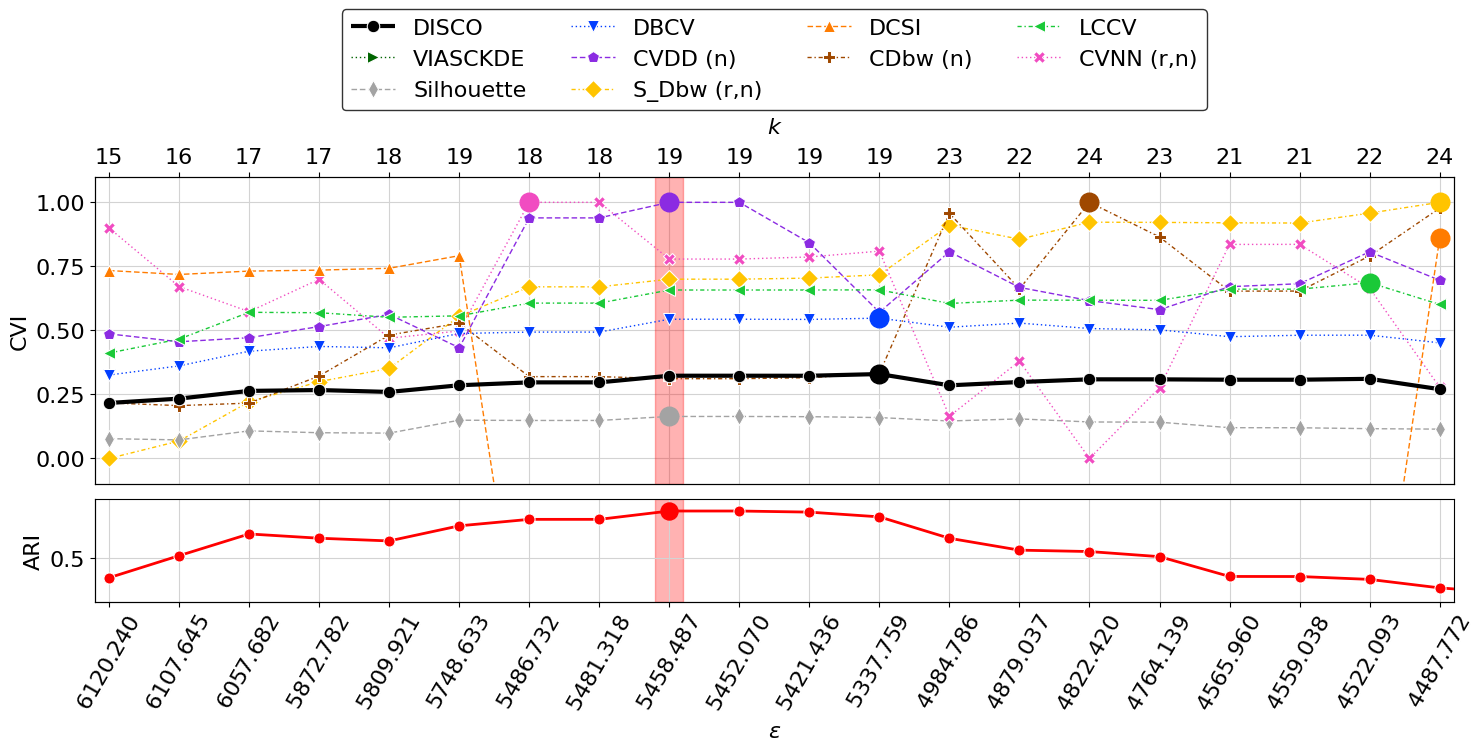

In [56]:
plot_func(
    df_ari,
    df,
    ks,
    eps_list[: len(ks)],
    peak_positions,
    ari_values,
    l,
    dbscan_labels[: len(ks)],
    save_name="COIL20_15_45",
)

In [16]:
data = {}
data2 = {}

In [61]:
DISCO_ROOT_PATH = "/export/share/pascalw777dm/DISCO"
sys.path.append(DISCO_ROOT_PATH)
os.environ["TZ"] = "Europe/Vienna"

from datasets.density_datasets import Datasets as DensityDatasets
from datasets.real_world_datasets import Datasets as RealWorldDatasets
from src.utils.metrics import create_and_rescale_df
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets


Datasets = [
    DensityDatasets.aggregation,
    DensityDatasets.chainlink,
    DensityDatasets.complex8,
    DensityDatasets.complex9,
    DensityDatasets.diamond9,
    DensityDatasets.compound,
    DensityDatasets.dartboard1,
    DensityDatasets.three_spiral,
    DensityDatasets.smile1,
    RealWorldDatasets.COIL20,
    RealWorldDatasets.Optdigits,
    # RealWorldDatasets.Pendigits,
    # RealWorldDatasets.Synth_high,
]

for dataset in Datasets:
    if dataset in data:
        print(f"{dataset.id}: Already in dict")
        continue

    print(dataset.id, end=": ")

    X, l = dataset.data_cached
    k_min, k_max = (2, len(set(l)) + 5)
    ks = range(k_min, k_max)

    eps_list, kcenter_labels, dbscan_labels = get_kcenter_and_dbscan_clusterings(X, ks)
    kcenter_datasets = [[(X, kcenter_labels[i])] for i, k in enumerate(ks)]
    dbscan_datasets = [[(X, dbscan_labels[i])] for i, k in enumerate(ks)]

    print(len(dbscan_datasets))

    ari_values = cache(f"find_dbscan_eps##ARIs##{dataset.id}", calc_ari_values, [l, dbscan_labels, ks], recalc=True)
    df_ari = create_df_ari(ari_values, ks)

    eval_results = cache(f"find_dbscan_eps##CVIs##{dataset.id}", calc_eval_measures_for_multiple_datasets, [dbscan_datasets, ks], {"n_jobs": 1})

    df = create_and_rescale_df(eval_results)
    peak_positions = get_peak_positions(df, ks)
    data[dataset] = [df_ari, df, ks, eps_list, peak_positions, ari_values, l]
    data2[dataset] = {
        "dbscan_labels": dbscan_labels,
        "kcenter_labels": kcenter_labels,
        "dbscan_datasets": dbscan_datasets,
        "kcenter_datasets": kcenter_datasets,
    }

aggregation: Already in dict
aggregation: 10
chainlink: Already in dict
chainlink: 

5
complex8: Already in dict
complex8: 11
complex9: Already in dict
complex9: 12
diamond9: Already in dict
diamond9: 12
compound: Already in dict
compound: 9
dartboard1: Already in dict
dartboard1: 7
three_spiral: Already in dict
three_spiral: 6
smile1: Already in dict
smile1: 7
COIL20: Already in dict
COIL20: 23
Optdigits: Already in dict
Optdigits: 13
Synth_high: 14


/export/share/pascalw777dm/DISCO/src/Evaluation/dbcv.py:44: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[distance_matrix != 0]) ** d
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/export/share/pascalw777dm/DISCO/src/Evaluation/dbcv.py:44: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[distance_matrix != 0]) ** d
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


KeyboardInterrupt: 

aggregation


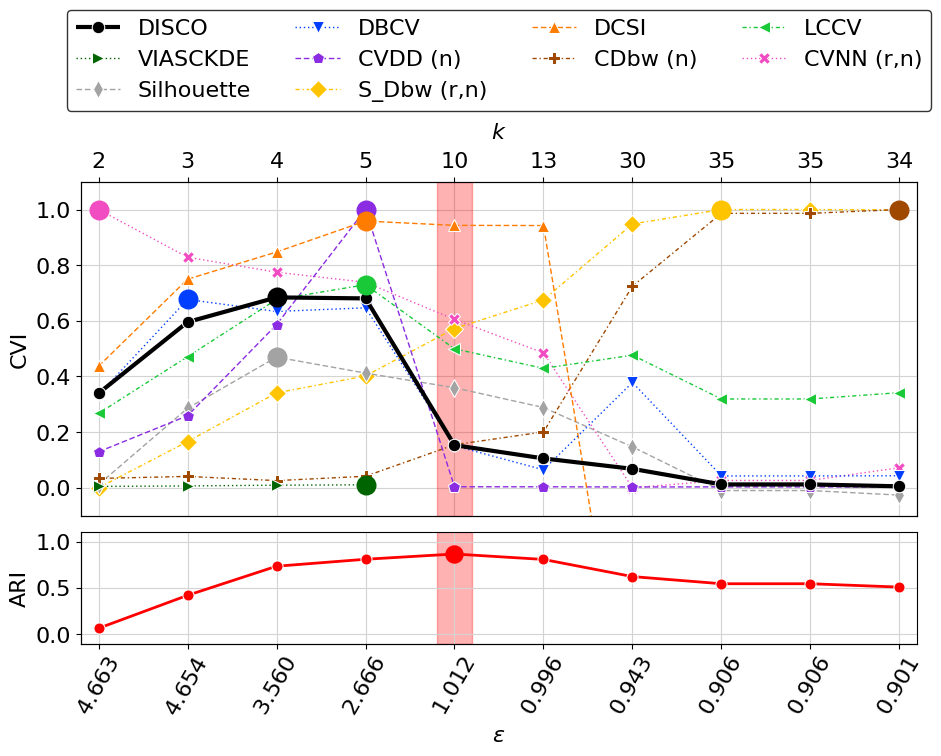

chainlink


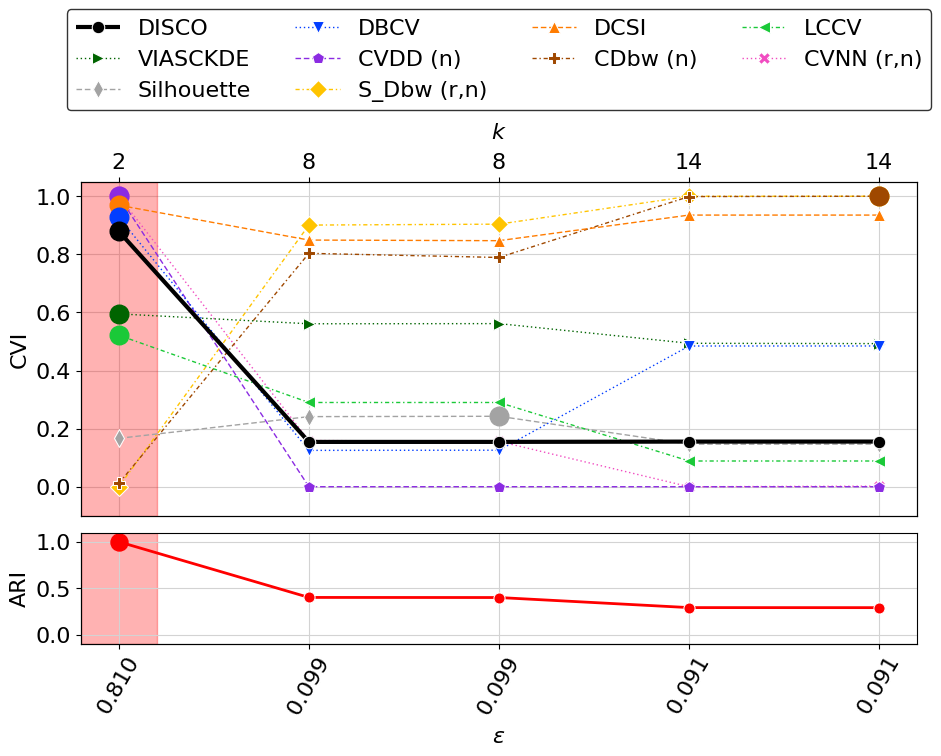

complex8


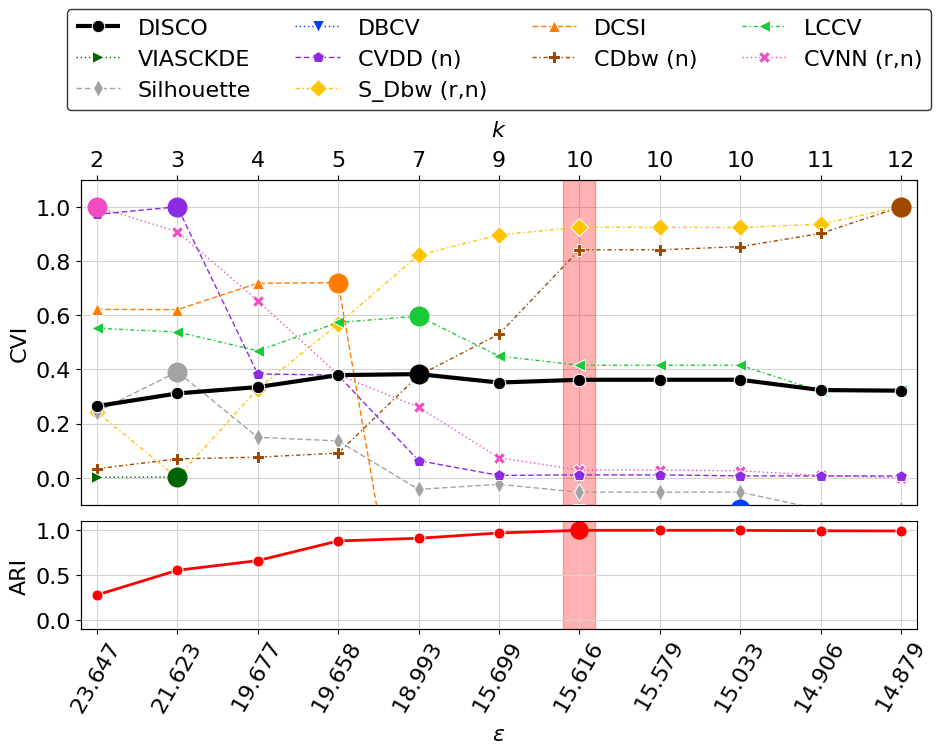

complex9


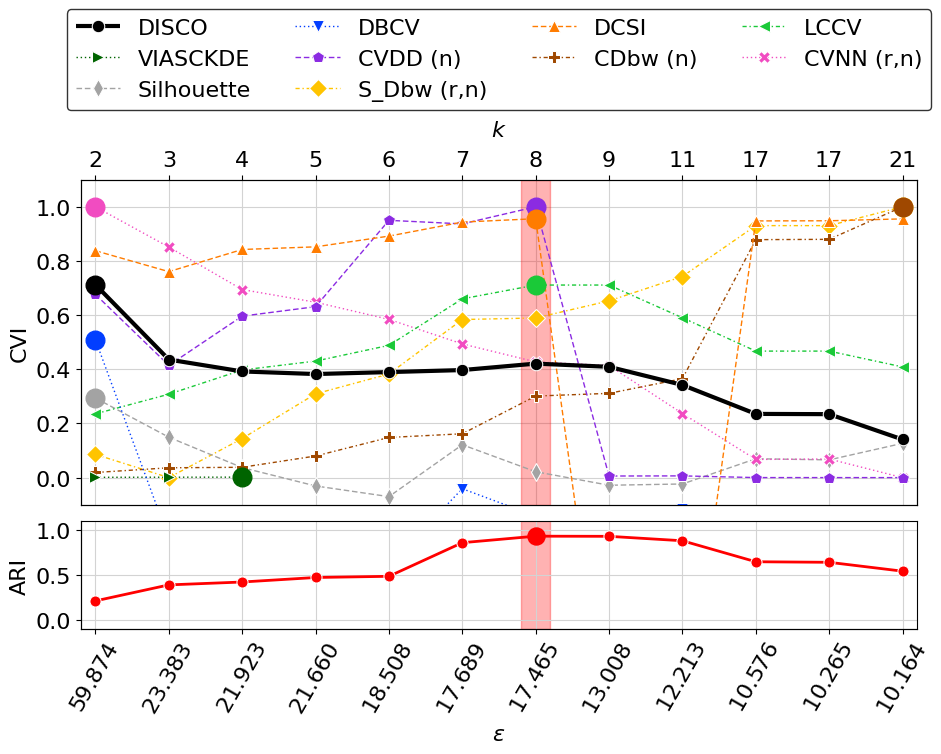

diamond9


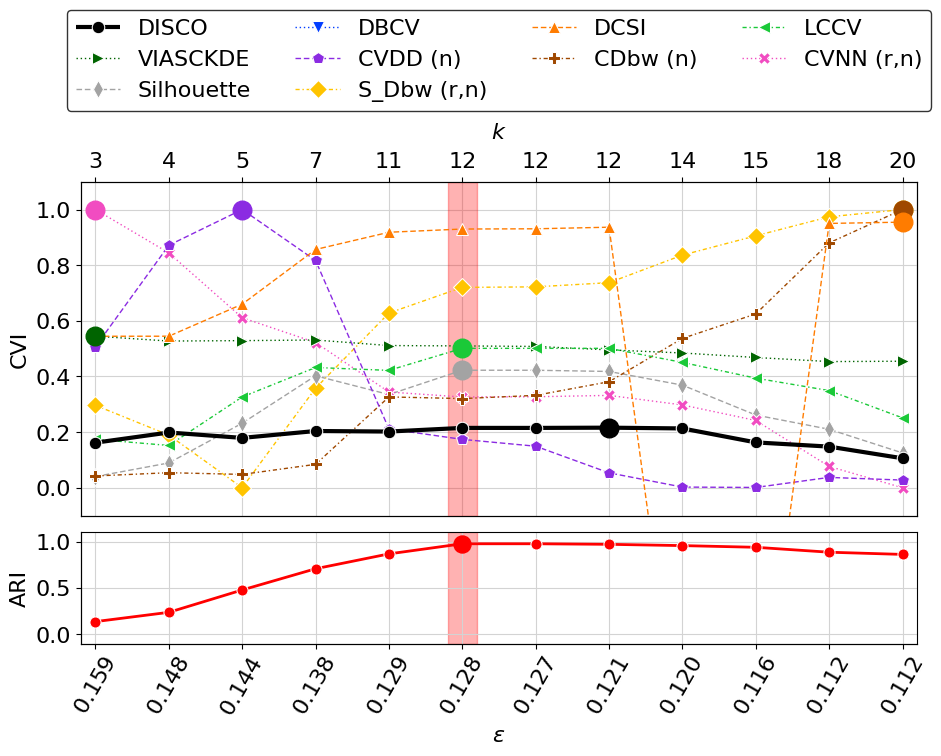

compound


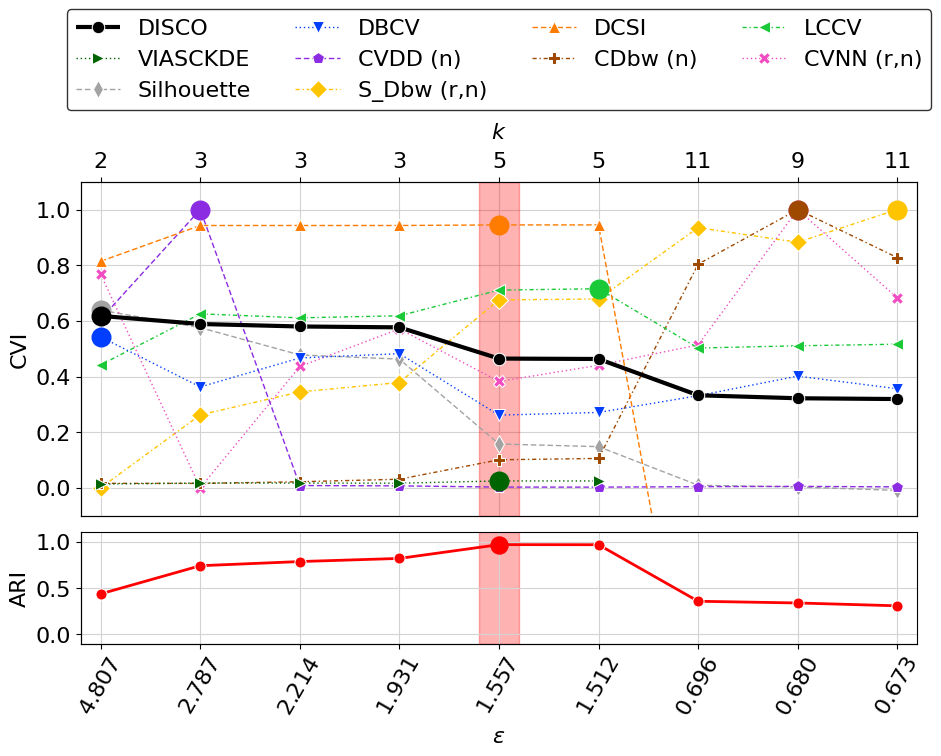

dartboard1


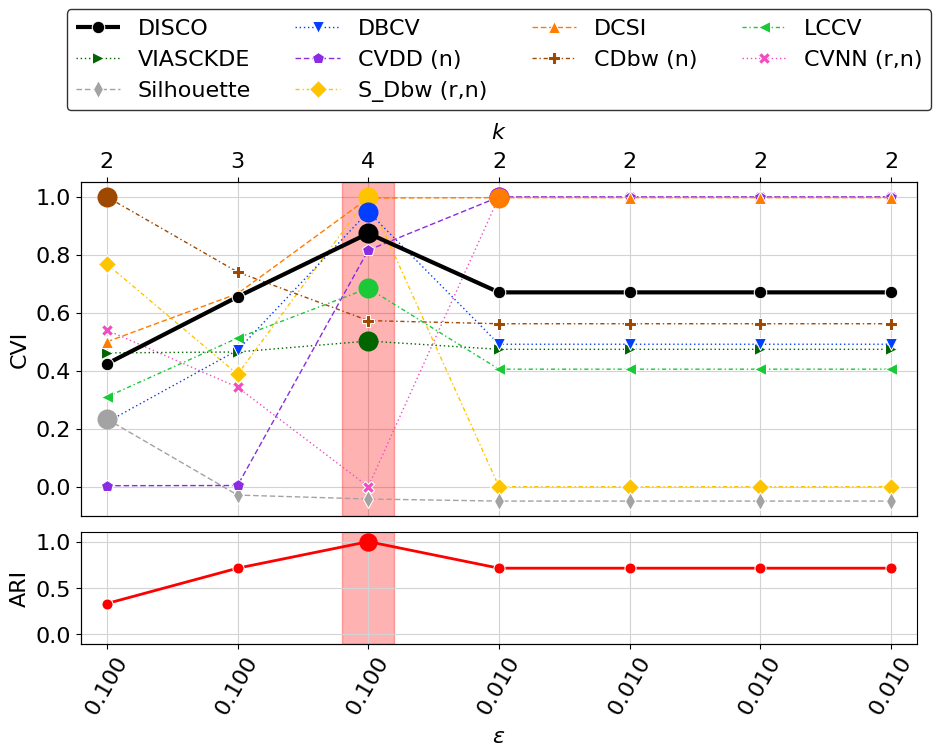

3-spiral


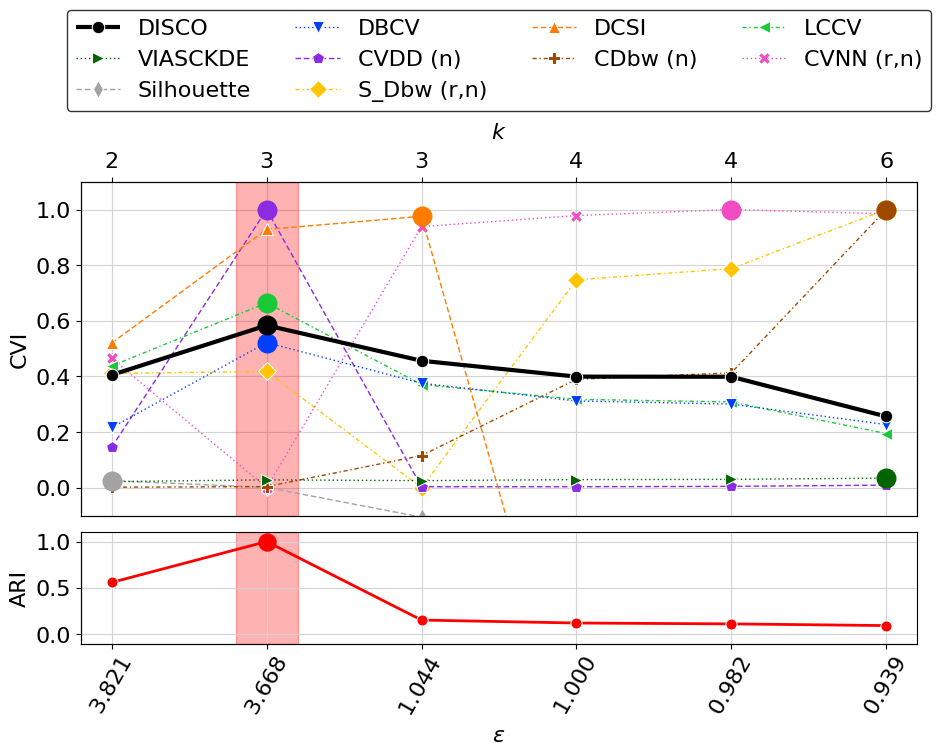

smile1


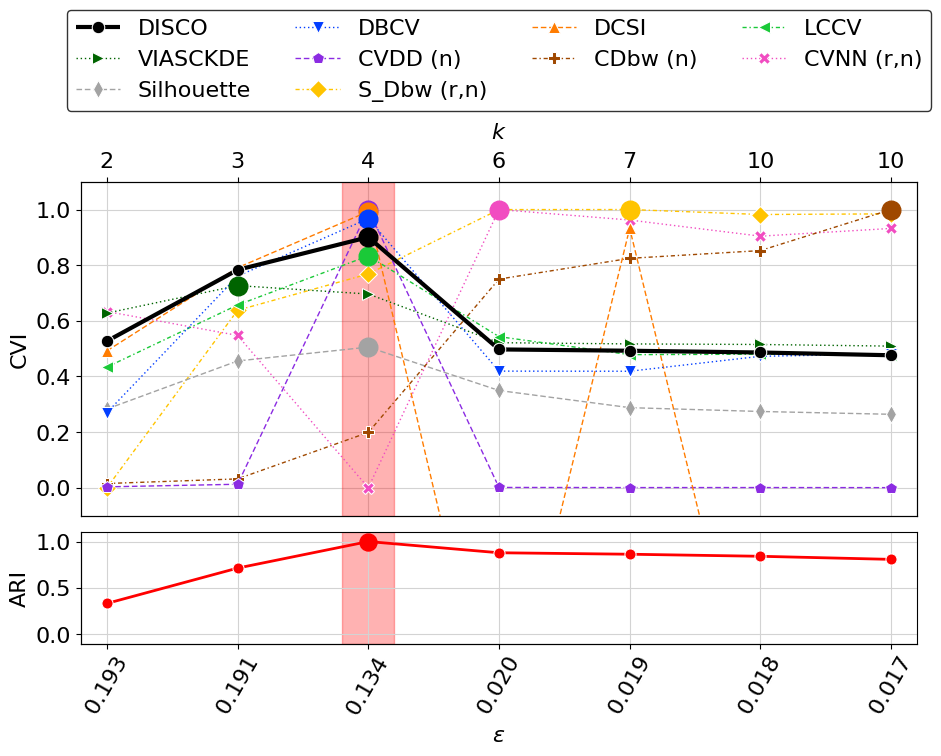

COIL20


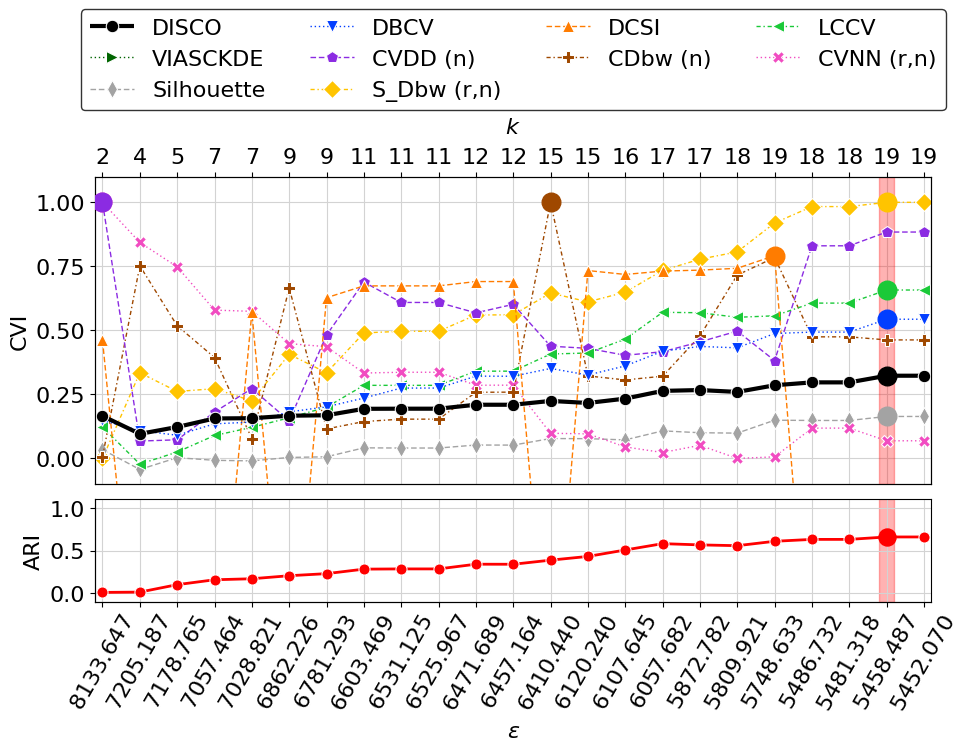

Optdigits


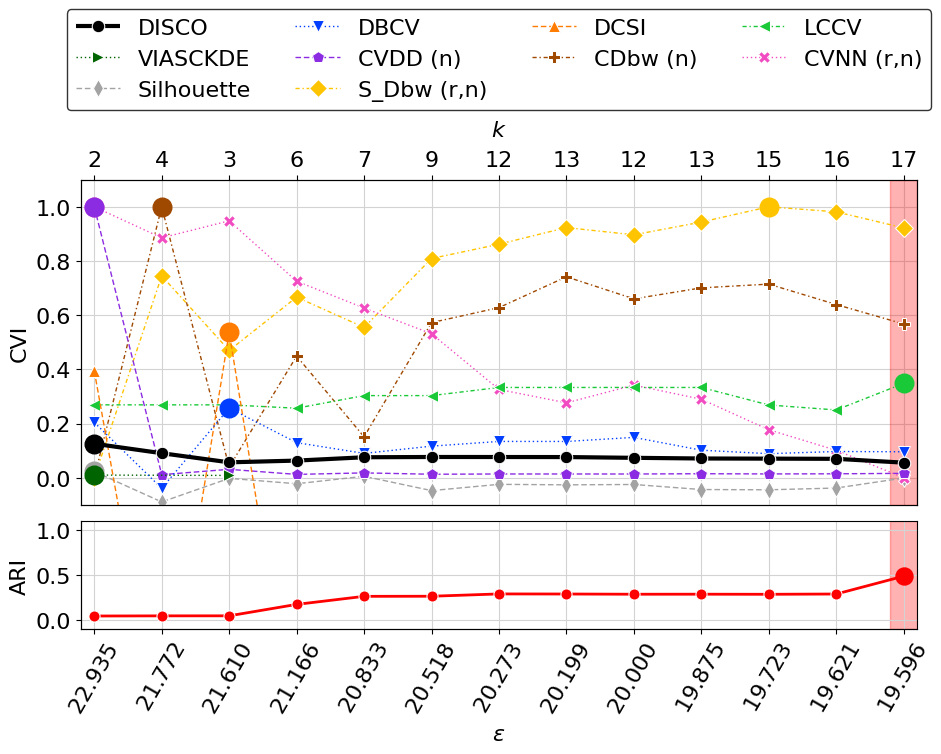

Synth_high


KeyError: <Datasets.Synth_high: 'Synth_high'>

In [74]:
dataset = DensityDatasets.chainlink

for dataset in Datasets:
    print(dataset.name)
    plot_func(*data[dataset], dbscan_labels=data2[dataset]["dbscan_labels"], save_name=dataset.id)

In [63]:
import numpy as np
from datasets.density_datasets import Datasets as DensityDatasets
from datasets.real_world_datasets import Datasets as RealWorldDatasets
from src.Evaluation.dcdistances.dctree import DCTree
from sklearn.cluster import DBSCAN
from src.Evaluation import disco_score, disco_samples

def disco_score_balanced(X, l):
    disco_values = disco_samples(X, l)
    disco_values_per_cluster = []
    for c in set(l):
        disco_values_per_cluster.append(disco_values[l==c].mean())
    return np.array(disco_values_per_cluster)

dataset = DensityDatasets.complex9
# dataset = DensityDatasets.aggregation
dataset = RealWorldDatasets.Synth_high
# dataset = RealWorldDatasets.COIL20
X, l = dataset.standardized_data_cached

ks = range(2, 20)
dctree = DCTree(X, min_points=5, min_points_mr=2)
eps_list = [dctree.get_eps_for_k(k) for k in ks]
kcenter_labels = [dctree.get_k_center(k) for k in ks]
dbscan_labels = [DBSCAN(eps).fit(X).labels_ for eps in eps_list]

# kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
# dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [64]:
kcenter_datasets = [[(X, kcenter_labels[i])] for i, k in enumerate(ks)]
dbscan_datasets = [[(X, dbscan_labels[i])] for i, k in enumerate(ks)]

In [66]:
from sklearn.metrics import adjusted_rand_score as ARI

ari_values = [(ARI(dbscan_labels[i][dbscan_labels[i] != -1], l[dbscan_labels[i] != -1])) for i, k in enumerate(ks)]
# list(enumerate(ari_values, 2))

In [67]:
import pandas as pd

df_ari = pd.DataFrame(ari_values, columns=["ARI"])
df_ari["k"] = range(2, len(ari_values) + 2)
df_ari["measure"] = "ARI"
# df_ari

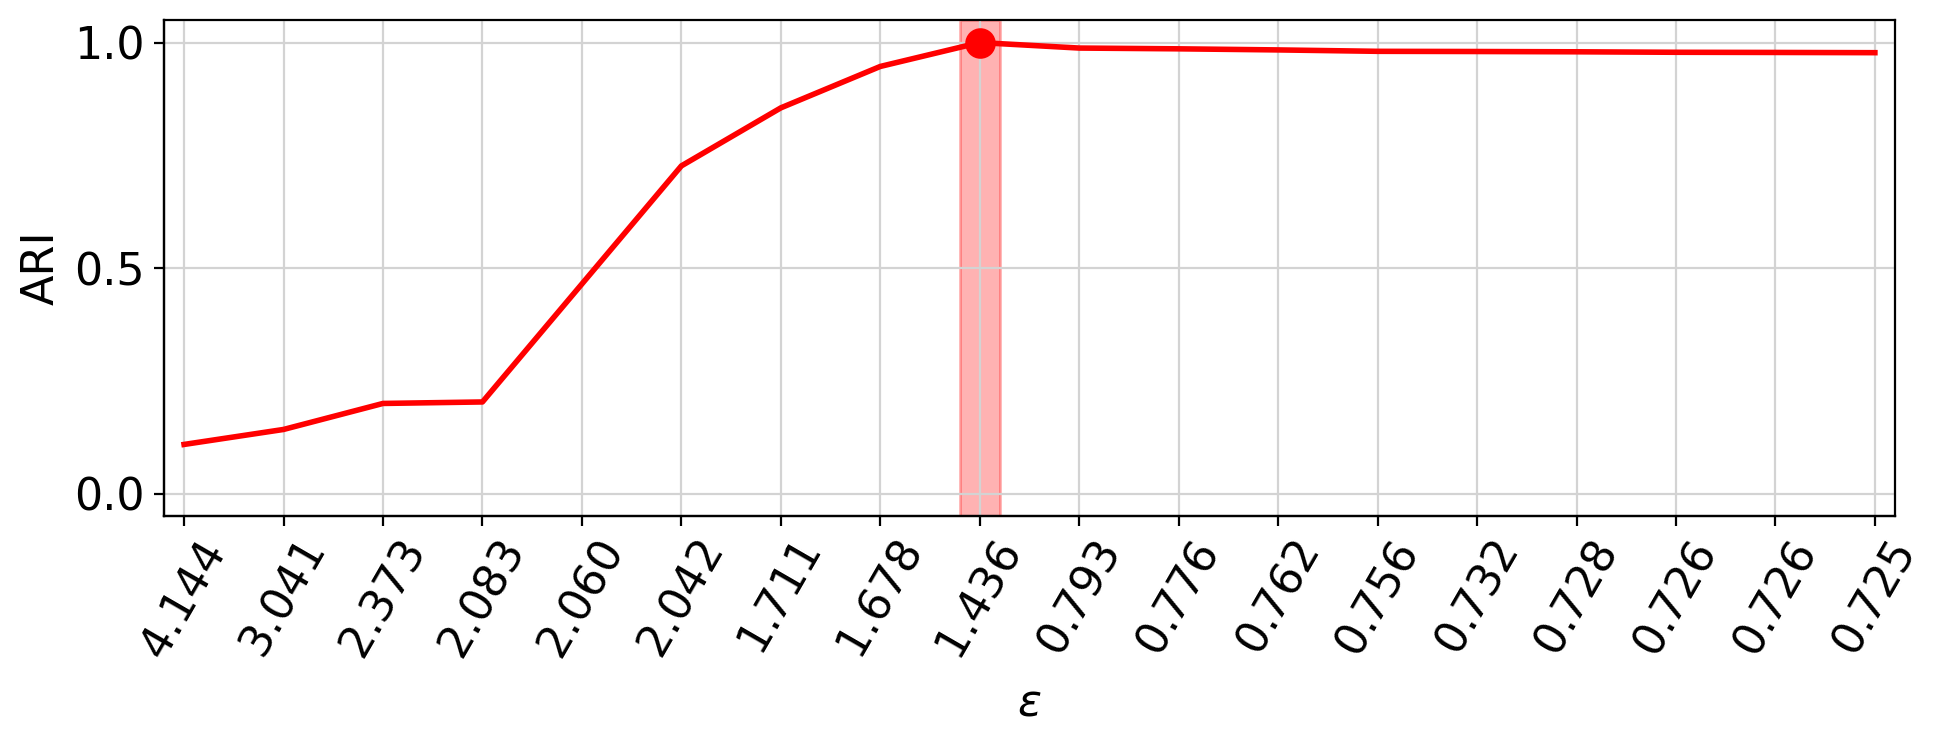

In [22]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot
import seaborn as sns

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plt.figure(
    figsize=(10, 4),
    dpi=200,
    layout="tight",
)

ax = sns.lineplot(
    data=df_ari,
    x="k",
    y="ARI",
    size="measure",
    sizes=[2],
    legend=False,
    color="red",
)

ax.set_xlim(*x_range)

### Coloring of the plot
ax.set_facecolor("white")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("white")
ax.spines["top"].set_color("white")
ax.grid(color="lightgray")


ax1 = fig.axes[0]
ax2 = ax1.twiny()
# ax2.set_xlabel("$k$", labelpad=10)
# ax2.set_xticks(ks)
# ax2.set_xlim(*x_range)
ax2.set_xticks([])
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("$\\epsilon$", labelpad=5)
ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)

x_peak, y_peak = np.argmax(ari_values) + 2, max(ari_values)
ax1.axvspan(x_peak - 0.2, x_peak + 0.2, alpha=0.3, color="red")
ax1.scatter(x_peak, y_peak, s=100, marker="o", color="red", zorder=3)

ax1.set_yticks([0, 0.5, 1])
ax1.set_ylim((-0.05, 1.05))


plt.savefig(f"imgs/find_eps_dbscan_ari/{dataset.id}.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [23]:
import pandas as pd
import glob

path = "results/find_dbscan_eps/"
dataframes = [pd.read_csv(path) for path in glob.glob(f"{path}*/*")]
df_ = pd.concat(dataframes).rename(columns={"function": "measure"})
df_["dataset"] = df_["dataset"].apply(lambda val: int(val.split("_")[-1]))
# df_["dataset"] = df_["dataset"].apply(lambda val: eps_list[val-2])
eval_results = df_.to_dict(orient="list")

In [68]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets

eval_results = cache(f"find_dbscan_eps##{dataset.id}", calc_eval_measures_for_multiple_datasets, [dbscan_datasets, ks], {"n_jobs": 1})
# eval_results = cache("find_dbscan_eps##complex9", calc_eval_measures_for_multiple_datasets, [dbscan_datasets, ks], {"n_jobs": 32})

In [69]:
from src.utils.metrics import create_and_rescale_df

df = create_and_rescale_df(eval_results)

In [70]:
df

,dataset,measure,run,value,time,process_time,mem_usage
0,2,DISCO,0,0.618416,2.411931,9.683404,8708096
1,2,DBCV,0,0.447083,2.377416,2.378332,16011264
2,2,DCSI,0,0.507246,3.514412,3.514556,-2490368
3,2,LCCV,0,0.004961,21.256362,21.257140,-16502784
4,2,VIASCKDE,0,0.046161,23.763103,23.769393,9994240
...,...,...,...,...,...,...,...
175,19,CVDD,0,0.120524,94.861417,94.974063,53915648
176,19,CDBW,0,0.012359,57.413070,57.510869,-52277248
177,19,CVNN,0,0.000000,0.460262,8.078487,18731008
178,19,SILHOUETTE,0,0.393634,0.304616,6.062269,159744


In [71]:
from src.utils.metrics import SELECTED_METRICS

cvi_scores = df.to_numpy()
peak_positions = []
all_values = []
for metric in SELECTED_METRICS:
    values = cvi_scores[cvi_scores[:, 1] == metric][:, 3]
    all_values.append(values)
    # print(metric, values)
    max_idx = np.argmax(values)
    print(max_idx, len(ks))
    peak_positions.append([ks[max_idx], values[max_idx], max_idx])
peak_positions = np.array(peak_positions)

8 18
8 18
9 18
17 18
17 18
8 18
3 18
0 18
0 18
17 18


In [14]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot
import seaborn as sns

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

palette = ["black"] + sns.color_palette("bright")[0:3] + ["darkgreen"] + sns.color_palette("bright")[4:-1]
np.array(list(palette), dtype=object)
palette = palette[: len(peak_positions)]


fig = plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    order=SELECTED_METRICS,
    x_label="$\\epsilon$",
    y_label="score",
    x_range=x_range,
    y_range=(None, None),
    figsize=(10, 5.5),
    # figsize=(10, 7.5),
    sizes=[3] + [1] * 10,
    markersize=7,
    palette=palette,
)
ax1 = fig.axes[0]
ax2 = ax1.twiny()
ax2.set_xlabel("$k$", labelpad=10)
ax2.set_xticks(ks)
ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_facecolor("none")
ax1.set_axisbelow(True)
ax1.spines["right"].set_color("black")
ax1.spines["top"].set_color("black")
ax2.grid(color="lightgray") # , linestyle="dashed")#
ax2.set_zorder(-1)

# ax1.set_xlabel("$\\epsilon$", labelpad=5)
# ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)
ax1.set_xlabel("")
ax1.set_xticks([])
ax1.axvspan(len(set(l[l!=-1])) - 0.2, len(set(l[l!=-1])) + 0.2, alpha=0.3, color="red")
ax1.get_legend().set_bbox_to_anchor((0.5, 1.18))

markers = ["o"] + ["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"]
markers = np.array(markers)[:len(peak_positions)]

for i in range(len(peak_positions)):
    ax1.scatter(peak_positions[i, 0], peak_positions[i, 1], s=120, marker="o", color=palette[i], zorder=3)


# fig.axes[0] = sns.lineplot(
#     data=df_ari,
#     x="k",
#     y="ARI",
#     size="measure",
#     sizes=[2],
#     legend=False,
# )


plt.savefig(f"imgs/find_eps_dbscan/{dataset.id}.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

ValueError: The palette dictionary is missing keys: {'S_DBW'}

<Figure size 2000x1100 with 0 Axes>

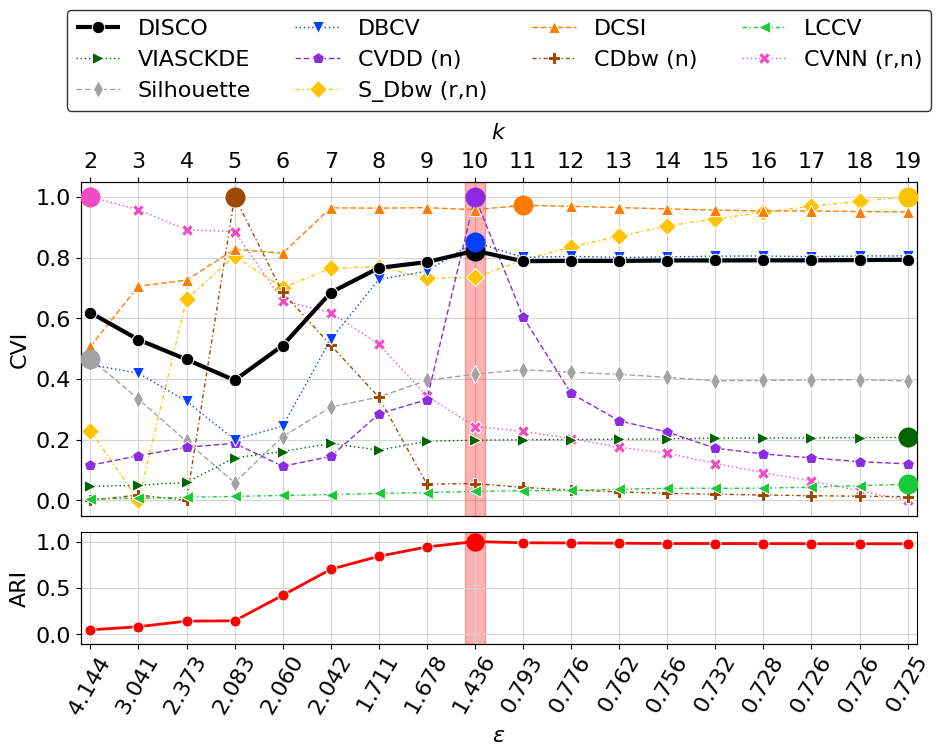

In [72]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot
import seaborn as sns

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

palette = ["black"] + sns.color_palette("bright")[0:3] + ["darkgreen"] + sns.color_palette("bright")[4:-1]
np.array(list(palette), dtype=object)
palette = palette[: len(peak_positions)]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [3, 1]})


plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    order=SELECTED_METRICS,
    x_label="$\\epsilon$",
    y_label="CVI",
    x_range=x_range,
    y_range=(None, None),
    figsize=(10, 5.5),
    # figsize=(10, 7.5),
    sizes=[3] + [1] * 10,
    markersize=9,
    palette=palette,
    fig=fig,
    ax=axes[0],
)
ax1 = axes[0]
ax2 = ax1.twiny()
ax2.set_xlabel("$k$", labelpad=10)
n_l = [len(set(l[l != 1])) for l in dbscan_labels]
ax2.set_xticks(ks, n_l)
ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_facecolor("none")
ax1.set_axisbelow(True)
ax1.spines["right"].set_color("black")
ax1.spines["top"].set_color("black")
ax2.grid(color="lightgray")  # , linestyle="dashed")#
ax2.set_zorder(-1)

# ax1.set_xlabel("$\\epsilon$", labelpad=5)
# ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)
ax1.set_xlabel("")
ax1.set_xticks([])
ax1.axvspan(len(set(l[l != -1])) - 0.2, len(set(l[l != -1])) + 0.2, alpha=0.3, color="red")
ax1.get_legend().set_bbox_to_anchor((0.5, 1.18))

markers = ["o"] + ["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"]
markers = np.array(markers)[: len(peak_positions)]

for i in range(len(peak_positions)):
    ax1.scatter(peak_positions[i, 0], peak_positions[i, 1], s=180, marker="o", color=palette[i], zorder=3)


# fig.axes[0] = sns.lineplot(
#     data=df_ari,
#     x="k",
#     y="ARI",
#     size="measure",
#     sizes=[2],
#     legend=False,
# )


eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

ax = sns.lineplot(
    data=df_ari,
    x="k",
    y="ARI",
    size="measure",
    sizes=[2],
    legend=False,
    color="red",
    ax=axes[1],
    marker="o",
    markersize=8,
)

ax.set_xlim(*x_range)

### Coloring of the plot
ax.set_facecolor("white")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("white")
ax.spines["top"].set_color("white")
ax.grid(color="lightgray")


ax1 = axes[1]
ax2 = ax1.twiny()
# ax2.set_xlabel("$k$", labelpad=10)
# ax2.set_xticks(ks)
# ax2.set_xlim(*x_range)
ax2.set_xticks([])
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("$\\epsilon$", labelpad=5)
ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)

x_peak, y_peak = np.argmax(ari_values) + 2, max(ari_values)
ax1.axvspan(x_peak - 0.2, x_peak + 0.2, alpha=0.3, color="red")
ax1.scatter(x_peak, y_peak, s=150, marker="o", color="red", zorder=3)

ax1.set_yticks([0,0.5, 1]) #, ["0.00", "0.50", "1.00"])
ax1.set_ylim((-0.1, 1.1))

plt.tight_layout()

plt.subplots_adjust(wspace=0.0, hspace=0.075)  # CHANGE SPACING HERE BETWEEN THE CLUSTER PLOTS
plt.savefig("imgs/find_eps_dbscan_both.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [22]:
import pandas as pd
import glob

path = "results/find_kcenter_k/"
dataframes = [pd.read_csv(path) for path in glob.glob(f"{path}*/*")]
df_ = pd.concat(dataframes).rename(columns={"function": "measure"})
df_["dataset"] = df_["dataset"].apply(lambda val: int(val.split("_")[-1]))
eval_results = df_.to_dict(orient="list")

In [23]:
from src.utils.metrics import create_and_rescale_df

df = create_and_rescale_df(eval_results)

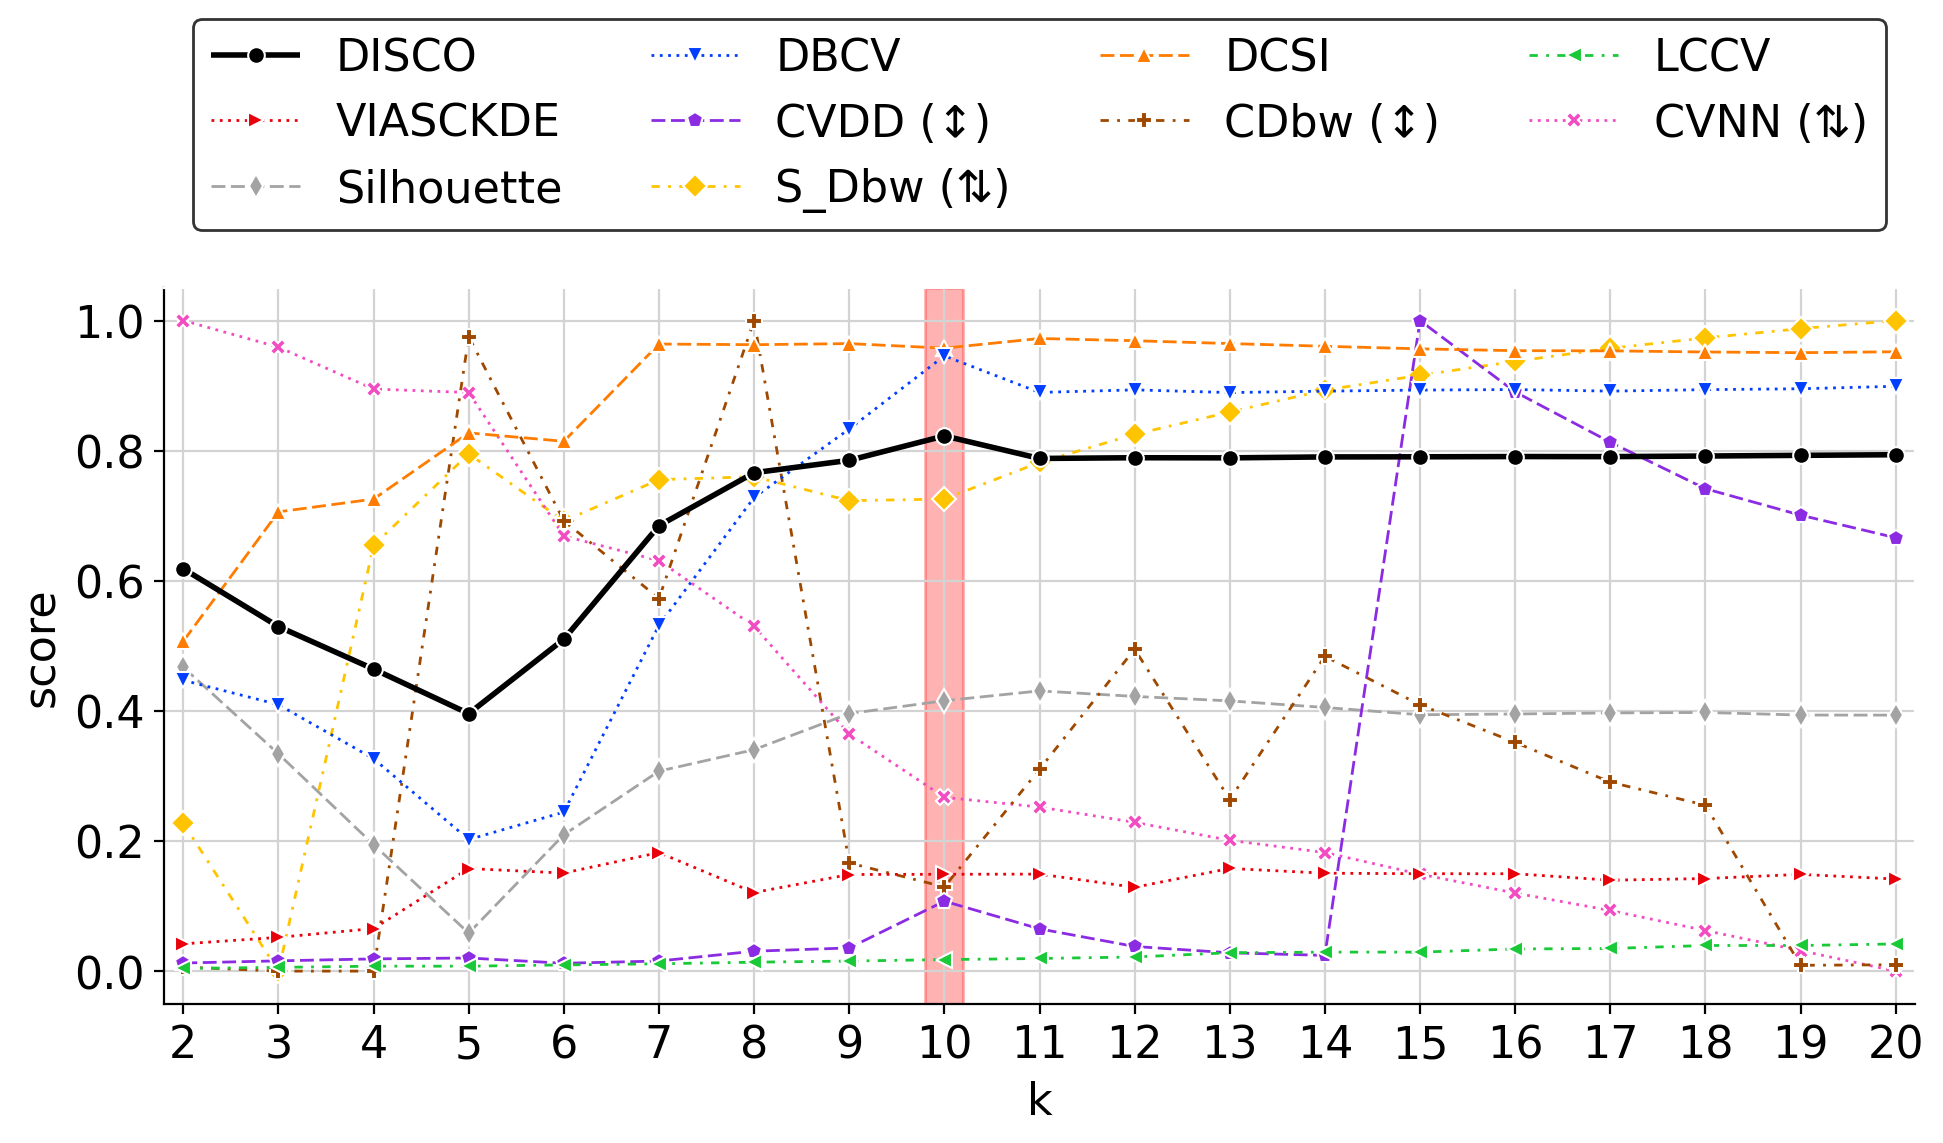

In [27]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(
    df, "dataset", "value", "measure", y_label="score", x_label="k", x_range=x_range, y_range=(None, None), figsize=(10,6)
)
ax1 = fig.axes[0]
# ax2 = ax1.twiny()
# ax2.set_xlabel("k", labelpad=10)
# ax2.set_xticks(ks)
# ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("k", labelpad=5)
ax1.set_xticks(ks)
ax1.axvspan(9.8, 10.2, alpha=0.3, color="red")
# ax1.get_legend().set_bbox_to_anchor((0.5, 1.20))
plt.savefig("imgs/find_k_kcenter.png", bbox_inches="tight", pad_inches=0)

In [168]:
import numpy as np
from datasets.density_datasets import Datasets as DensityDatasets
from datasets.real_world_datasets import Datasets as RealWorldDatasets
from src.Evaluation.dcdistances.dctree import DCTree
from sklearn.cluster import DBSCAN
from src.Evaluation import disco_score, disco_samples

def disco_score_balanced(X, l):
    disco_values = disco_samples(X, l)
    disco_values_per_cluster = []
    for c in set(l):
        disco_values_per_cluster.append(disco_values[l==c].mean())
    return np.array(disco_values_per_cluster)

# dataset = DensityDatasets.complex9
dataset = DensityDatasets.aggregation
# dataset = RealWorldDatasets.Synth_high
X, l = dataset.standardized_data_cached

ks = range(2, 21)
dctree = DCTree(X, min_points=5, min_points_mr=2)
eps_list = [dctree.get_eps_for_k(k) for k in ks]
kcenter_labels = [dctree.get_k_center(k) for k in ks]
dbscan_labels = [DBSCAN(eps).fit(X).labels_ for eps in eps_list]

# kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
# dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [169]:
kcenter_datasets = [[(X, kcenter_labels[i])] for i, k in enumerate(ks)]
dbscan_datasets = [[(X, dbscan_labels[i])] for i, k in enumerate(ks)]

In [174]:
print("kcenter_k:", [len(set(l_)) for l_ in kcenter_labels])
print("dbscan_k:", [len(set(l_)) for l_ in dbscan_labels])

kcenter_k: [2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
dbscan_k: [2, 3, 4, 5, 27, 27, 28, 32, 32, 38, 38, 36, 39, 39, 38, 36, 35, 33, 34]


In [171]:
kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [172]:
import pandas as pd

data_dict = {
    "k": ks,
    "eps": eps_list,
    "kcenter_disco": kcenter_disco_results,
    "dbscan_disco": dbscan_disco_results,
    "dataset": dataset.name,
}

df = pd.DataFrame(data_dict)

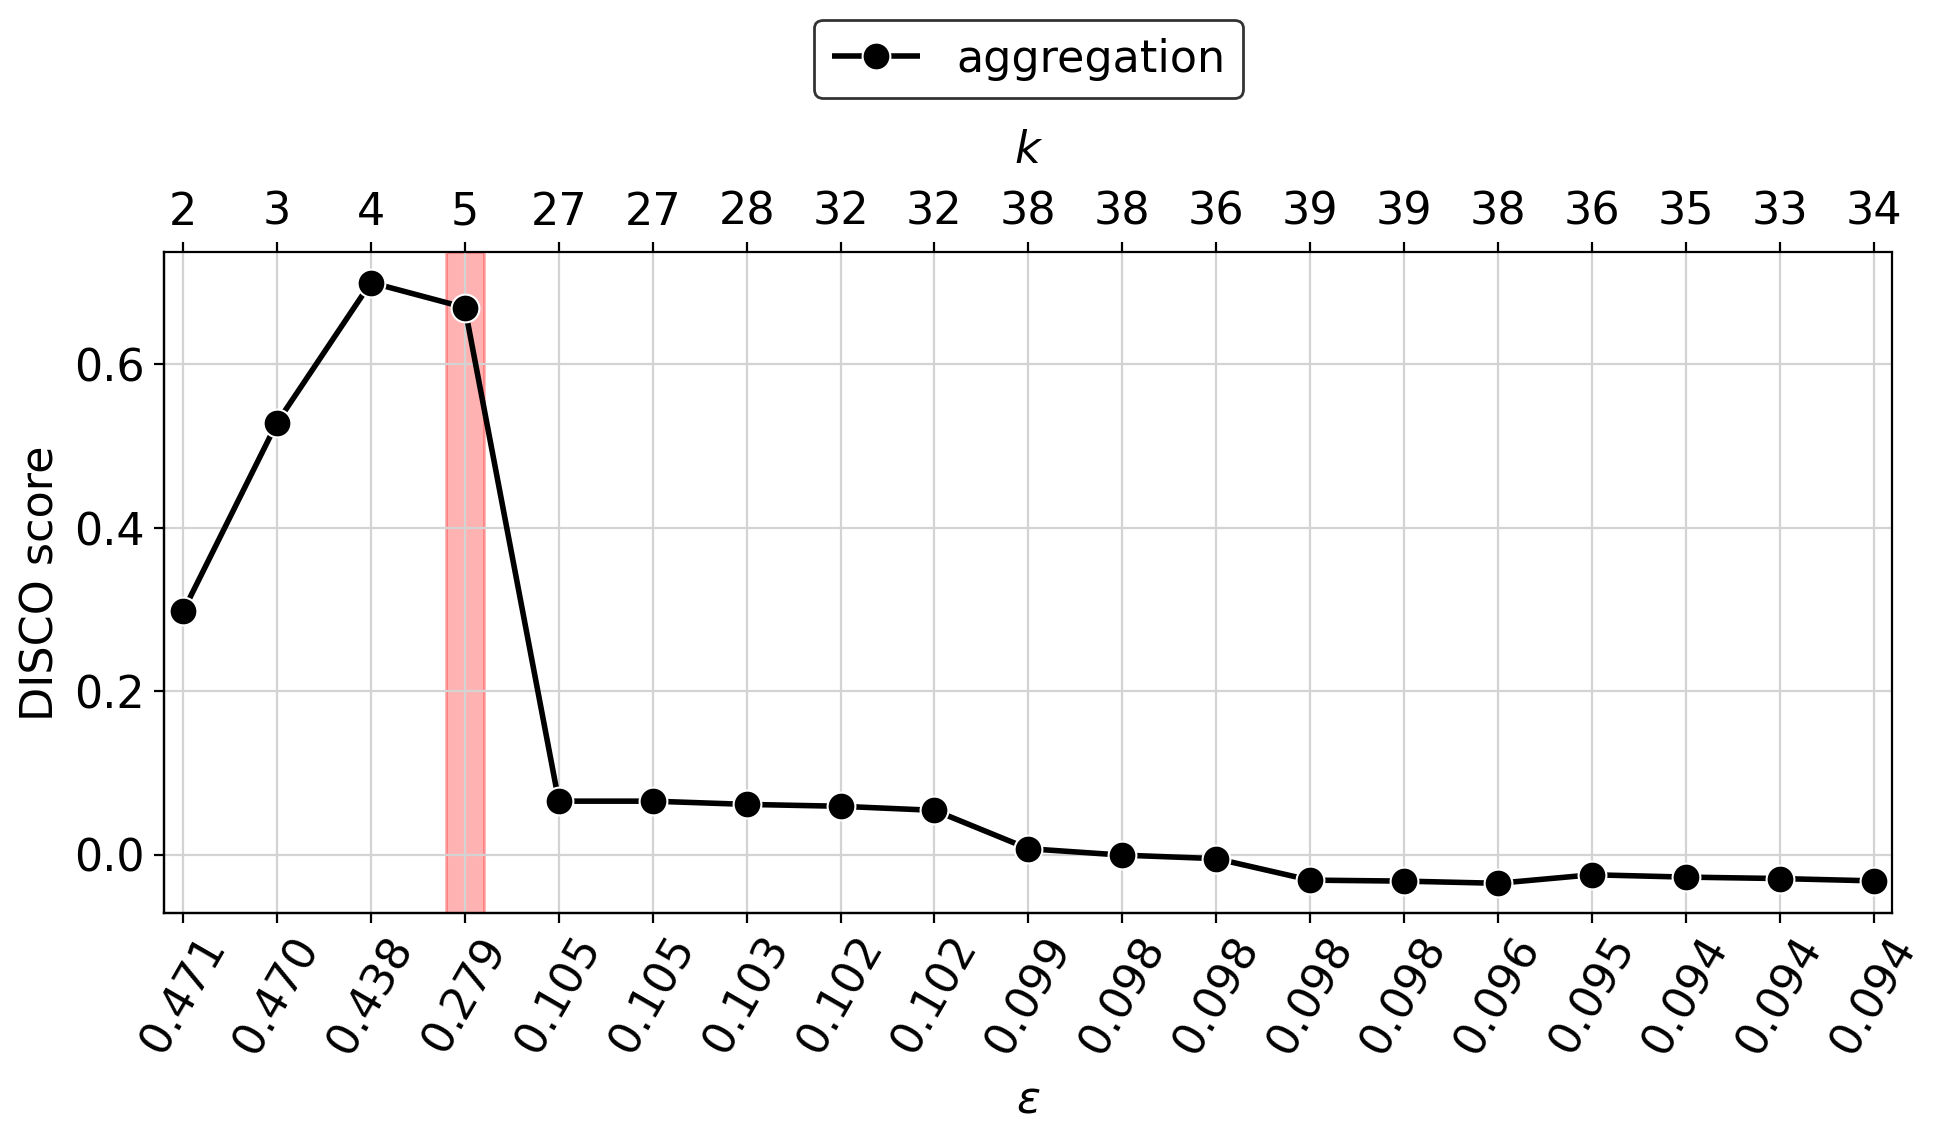

In [177]:
from src.utils.plots import plot_lineplot
import matplotlib.pyplot as plt

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(df, "k", "dbscan_disco", "dataset", x_label="epsilon", y_label="DISCO score", x_range=x_range, y_range=(None, None), order=[dataset.name])
ax1 = fig.axes[0]
ax2 = ax1.twiny()
ax2.set_xlabel("$k$", labelpad=10)
ax2.set_xticks(ks, [len(set(l_)) for l_ in dbscan_labels])
ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("$\\epsilon$", labelpad=5)

ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)
ax1.axvspan(4.8, 5.2, alpha=0.3, color="red")
ax1.get_legend().set_bbox_to_anchor((0.5, 1.20))
plt.savefig("imgs/aggregation_find_k_eps.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [132]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    return colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )

cmap = truncate_colormap(plt.colormaps["gist_rainbow"], 0.0, 0.85)

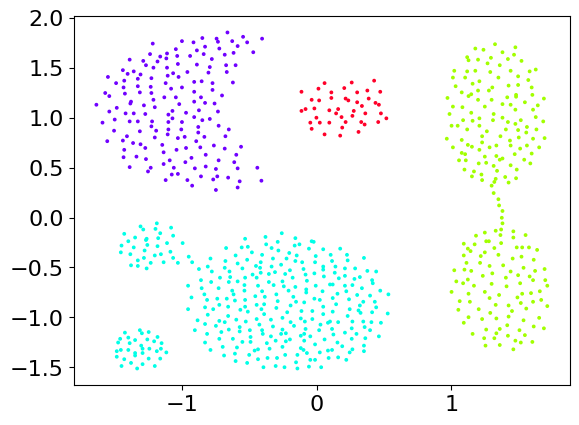

In [133]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=kcenter_labels[np.argmax(kcenter_disco_results)], cmap=cmap)
plt.show()

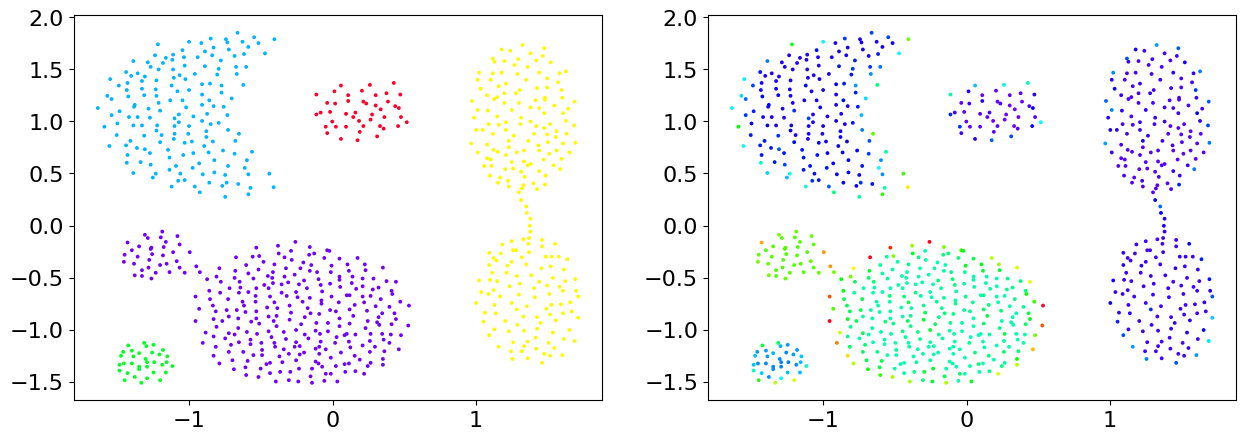

In [134]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=3, c=kcenter_labels[3], cmap=cmap)
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], s=3, c=disco_samples(X, kcenter_labels[3]), cmap=cmap)
plt.show()

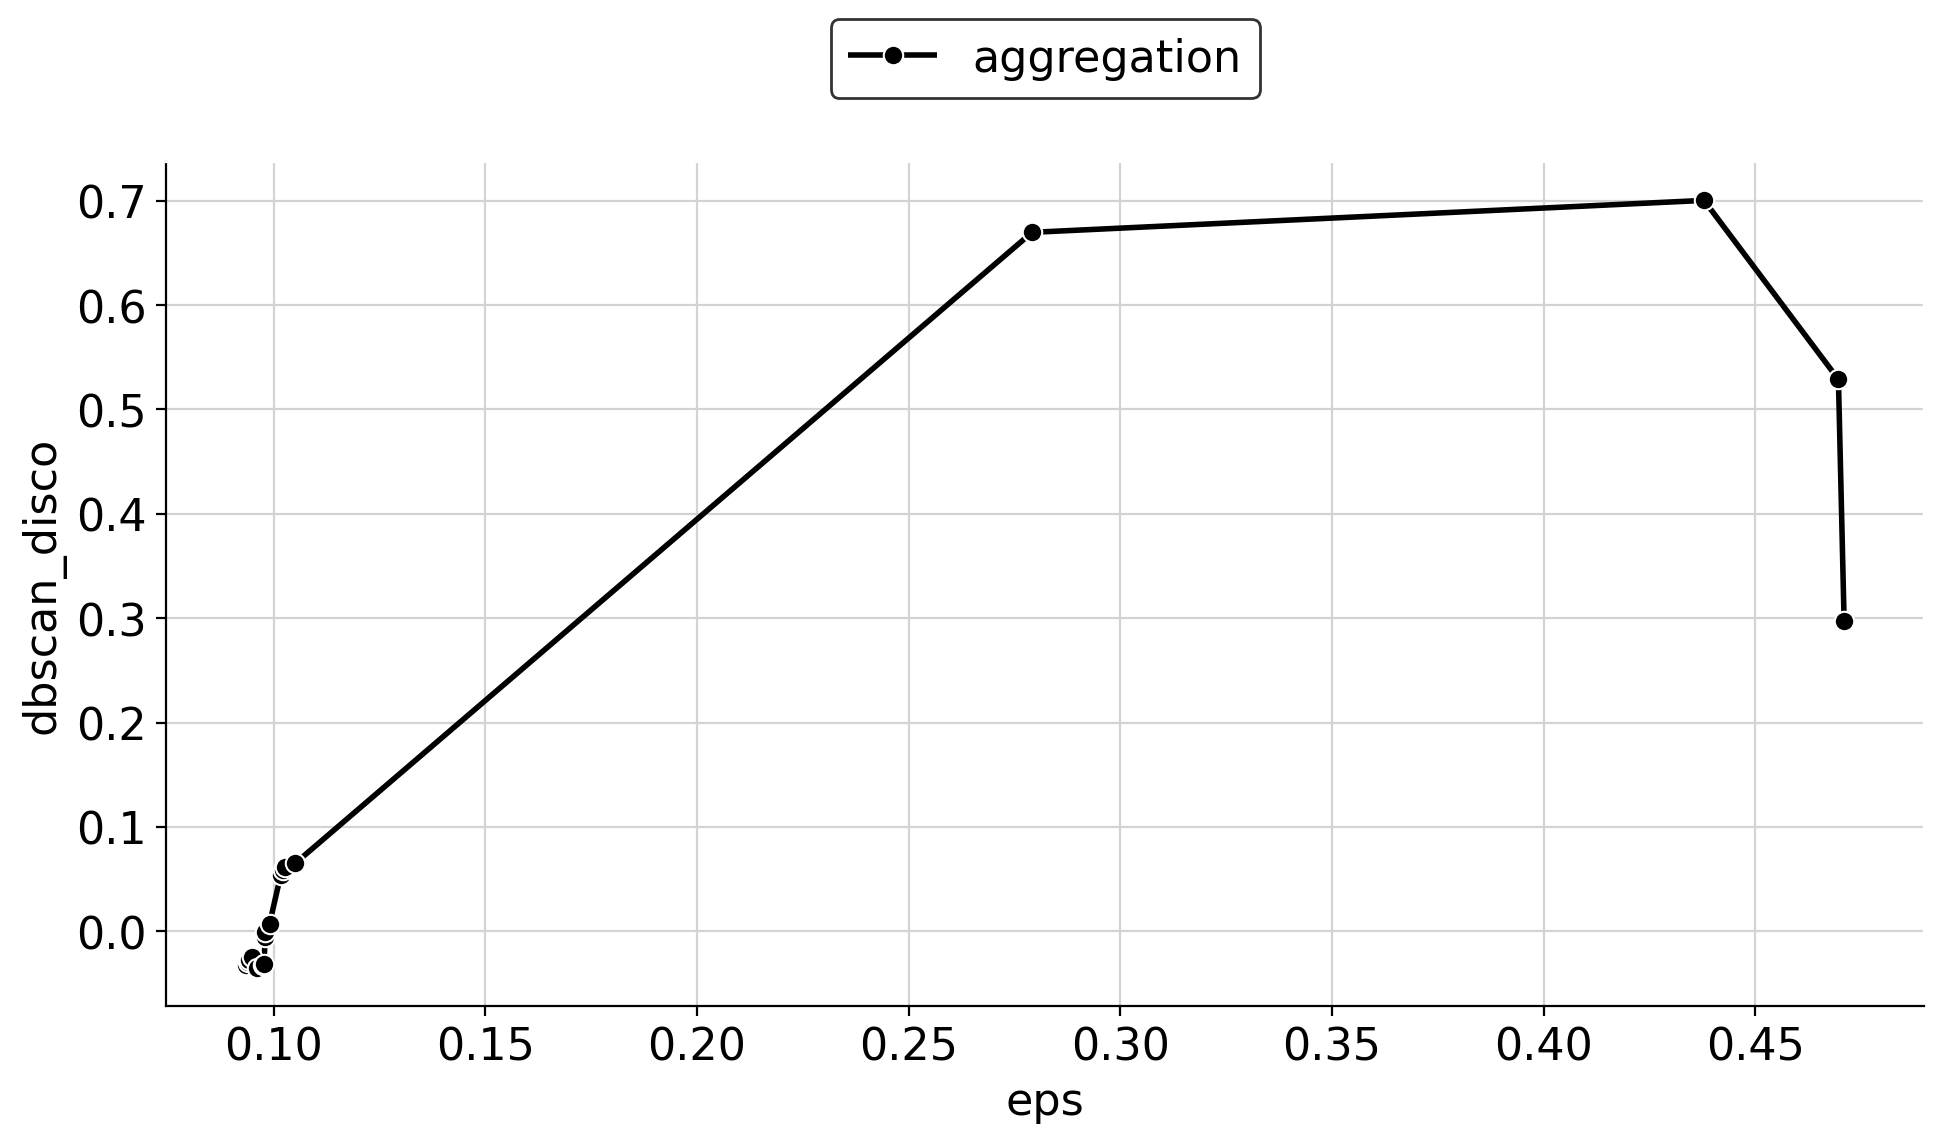

In [135]:
from src.utils.plots import plot_lineplot
import matplotlib.pyplot as plt

eps = 1
x_range = None, None

plot_lineplot(df, "eps", "dbscan_disco", "dataset", x_range=x_range, y_range=(None, None), order=[dataset.name])
plt.savefig("imgs/Synth_high_find_eps.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

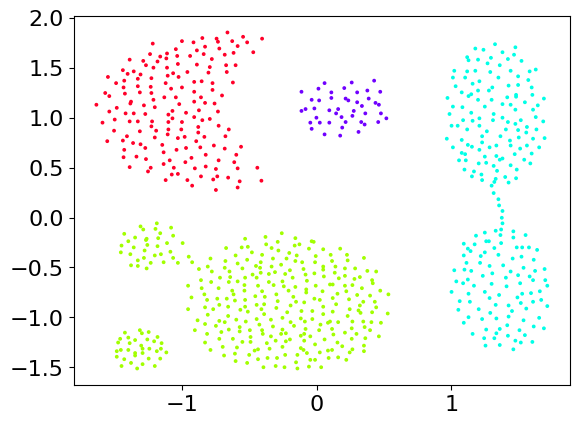

In [20]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=dbscan_labels[np.argmax(dbscan_disco_results)], cmap=cmap)
plt.show()

In [52]:
import numpy as np 

l__ = np.random.choice(170, len(l))
print(f"Nr of Clusters: {len(set(l__))}, DISCO: {disco_score(X, l__)}")

Nr of Clusters: 168, DISCO: -0.6228814662690386


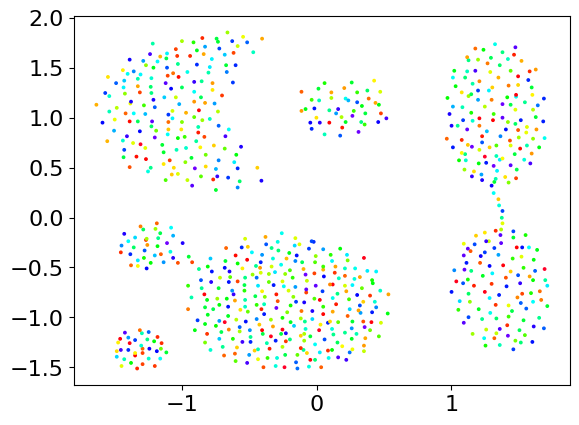

In [53]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=l__, cmap=cmap)
plt.show()

In [ ]:
from src.Evaluation import disco_score
import numpy as np

ks = np.array([range(1, 300) for j in range(10)]).flatten()

np.random.seed(0)

ls = [np.random.choice(i, len(l)) for i in ks]
disco_values = [disco_score(X, l) for l in ls]

In [ ]:
results = np.hstack((np.array(ls), ks[:, np.newaxis], np.array(disco_values)[:, np.newaxis]))
np.save(".cache/increasing_labelset.npy", results)

In [137]:
results = np.load(".cache/increasing_labelset.npy")
ls = results[:, :-2]
ks = results[:, -2]
disco_values = results[:, -1]

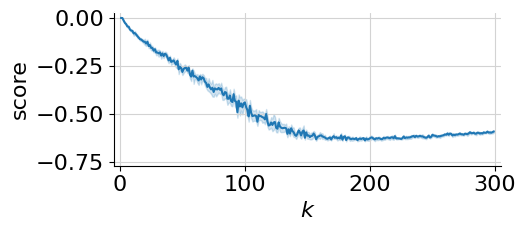

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_dict = {
    "k": ks,
    "disco": disco_values,
}
df = pd.DataFrame(data_dict)

plt.figure(figsize=(5, 2))
ax = sns.lineplot(df, x="k", y="disco")
ax.set_xlabel("$k$")
ax.set_ylabel("score")
ax.set_ylim(-0.77, None)
ax.set_yticks(np.arange(-0.75,0.1, 0.25))
ax.set_xlim(-5, 305)

ax.set_facecolor("white")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("white")
ax.spines["top"].set_color("white")
ax.grid(color="lightgray")

plt.savefig("imgs/increasing_labelset.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()